##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Text Classification with Movie Reviews

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem. 

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews. 

This notebook uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow, and [TensorFlow Hub](https://www.tensorflow.org/hub), a library and platform for transfer learning. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

### More models
[Here](https://tfhub.dev/s?module-type=text-embedding) you can find more expressive or performant models that you could use to generate the text embedding.

## Setup

In [3]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.3.1
Eager mode:  True
Hub version:  0.9.0


GPU is available


## Download the IMDB dataset

The IMDB dataset is available on [TensorFlow datasets](https://github.com/tensorflow/datasets). The following code downloads the IMDB dataset to your machine (or the colab runtime):

In [4]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1BWJS5/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1BWJS5/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1BWJS5/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /home/kbuilder/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Explore the data 

Let's take a moment to understand the format of the data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [5]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


Let's print first 10 examples.

In [6]:
train_examples[:10]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

Let's also print the first 10 labels.

In [7]:
train_labels[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

## Build the model

The neural network is created by stacking layers—this requires three main architectural decisions:

* How to represent the text?
* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have two advantages:
*   we don't have to worry about text preprocessing,
*   we can benefit from transfer learning.

For this example we will use a model from [TensorFlow Hub](https://www.tensorflow.org/hub) called [google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1).

There are three other models to test for the sake of this tutorial:
* [google/tf2-preview/gnews-swivel-20dim-with-oov/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) - same as [google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1), but with 2.5% vocabulary converted to OOV buckets. This can help if vocabulary of the task and vocabulary of the model don't fully overlap.
* [google/tf2-preview/nnlm-en-dim50/1](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1) - A much larger model with ~1M vocabulary size and 50 dimensions.
* [google/tf2-preview/nnlm-en-dim128/1](https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1) - Even larger model with ~1M vocabulary size and 128 dimensions.

Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that the output shape of the produced embeddings is a expected: `(num_examples, embedding_dimension)`.

In [8]:
model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(model, output_shape=[20], input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

Let's now build the full model:

In [9]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The model that we are using ([google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1)) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: `(num_examples, embedding_dimension)`.
2. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
3. The last layer is densely connected with a single output node. This outputs logits: the log-odds of the true class, according to the model.

### Hidden units

The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called *overfitting*, and we'll explore it later.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the `binary_crossentropy` loss function. 

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [10]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

## Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen before. Create a *validation set* by setting apart 10,000 examples from the original training data. (Why not use the testing set now? Our goal is to develop and tune our model using only the training data, then use the test data just once to evaluate our accuracy).

In [11]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Train the model

Train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [12]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40


 1/30 [>.............................] - ETA: 0s - loss: 0.9238 - accuracy: 0.4453

 3/30 [==>...........................] - ETA: 0s - loss: 0.9494 - accuracy: 0.3939

 5/30 [====>.........................] - ETA: 0s - loss: 0.9327 - accuracy: 0.3965

 7/30 [======>.......................] - ETA: 0s - loss: 0.9110 - accuracy: 0.4068

 9/30 [========>.....................] - ETA: 0s - loss: 0.9078 - accuracy: 0.4058

11/30 [==========>...................] - ETA: 0s - loss: 0.8937 - accuracy: 0.4066

13/30 [============>.................] - ETA: 0s - loss: 0.8798 - accuracy: 0.4118

15/30 [==============>...............] - ETA: 0s - loss: 0.8690 - accuracy: 0.4189

17/30 [================>.............] - ETA: 0s - loss: 0.8600 - accuracy: 0.4228

19/30 [==================>...........] - ETA: 0s - loss: 0.8504 - accuracy: 0.4266

21/30 [====================>.........] - ETA: 0s - loss: 0.8399 - accuracy: 0.4337

23/30 [======================>.......] - ETA: 0s - loss: 0.8302 - accuracy: 0.4412

25/30 [========================>.....] - ETA: 0s - loss: 0.8218 - accuracy: 0.4497

27/30 [==========================>...] - ETA: 0s - loss: 0.8129 - accuracy: 0.4574

29/30 [============================>.] - ETA: 0s - loss: 0.8056 - accuracy: 0.4626

30/30 [==============================] - 2s 54ms/step - loss: 0.8047 - accuracy: 0.4633 - val_loss: 0.6867 - val_accuracy: 0.5756


Epoch 2/40
 1/30 [>.............................] - ETA: 0s - loss: 0.6977 - accuracy: 0.5586

 3/30 [==>...........................] - ETA: 0s - loss: 0.6901 - accuracy: 0.5625

 5/30 [====>.........................] - ETA: 0s - loss: 0.6865 - accuracy: 0.5605

 7/30 [======>.......................] - ETA: 0s - loss: 0.6790 - accuracy: 0.5751

 9/30 [========>.....................] - ETA: 0s - loss: 0.6740 - accuracy: 0.5836

11/30 [==========>...................] - ETA: 0s - loss: 0.6719 - accuracy: 0.5866

13/30 [============>.................] - ETA: 0s - loss: 0.6682 - accuracy: 0.5930

15/30 [==============>...............] - ETA: 0s - loss: 0.6639 - accuracy: 0.5995

17/30 [================>.............] - ETA: 0s - loss: 0.6622 - accuracy: 0.6031

19/30 [==================>...........] - ETA: 0s - loss: 0.6597 - accuracy: 0.6070

21/30 [====================>.........] - ETA: 0s - loss: 0.6558 - accuracy: 0.6136

23/30 [======================>.......] - ETA: 0s - loss: 0.6532 - accuracy: 0.6171

25/30 [========================>.....] - ETA: 0s - loss: 0.6512 - accuracy: 0.6205

27/30 [==========================>...] - ETA: 0s - loss: 0.6487 - accuracy: 0.6225

29/30 [============================>.] - ETA: 0s - loss: 0.6468 - accuracy: 0.6239

30/30 [==============================] - 1s 48ms/step - loss: 0.6467 - accuracy: 0.6240 - val_loss: 0.6269 - val_accuracy: 0.6545


Epoch 3/40
 1/30 [>.............................] - ETA: 0s - loss: 0.6117 - accuracy: 0.6875

 3/30 [==>...........................] - ETA: 0s - loss: 0.6326 - accuracy: 0.6432

 5/30 [====>.........................] - ETA: 0s - loss: 0.6205 - accuracy: 0.6605

 7/30 [======>.......................] - ETA: 0s - loss: 0.6145 - accuracy: 0.6666

 9/30 [========>.....................] - ETA: 0s - loss: 0.6137 - accuracy: 0.6658

11/30 [==========>...................] - ETA: 0s - loss: 0.6141 - accuracy: 0.6644

13/30 [============>.................] - ETA: 0s - loss: 0.6118 - accuracy: 0.6692

15/30 [==============>...............] - ETA: 0s - loss: 0.6095 - accuracy: 0.6716

17/30 [================>.............] - ETA: 0s - loss: 0.6086 - accuracy: 0.6720

19/30 [==================>...........] - ETA: 0s - loss: 0.6059 - accuracy: 0.6760

21/30 [====================>.........] - ETA: 0s - loss: 0.6057 - accuracy: 0.6749

23/30 [======================>.......] - ETA: 0s - loss: 0.6036 - accuracy: 0.6771

25/30 [========================>.....] - ETA: 0s - loss: 0.6031 - accuracy: 0.6771

27/30 [==========================>...] - ETA: 0s - loss: 0.6014 - accuracy: 0.6790

29/30 [============================>.] - ETA: 0s - loss: 0.6017 - accuracy: 0.6790

30/30 [==============================] - 1s 48ms/step - loss: 0.6015 - accuracy: 0.6789 - val_loss: 0.5927 - val_accuracy: 0.6891


Epoch 4/40
 1/30 [>.............................] - ETA: 0s - loss: 0.5630 - accuracy: 0.7051

 3/30 [==>...........................] - ETA: 0s - loss: 0.5727 - accuracy: 0.7148

 5/30 [====>.........................] - ETA: 0s - loss: 0.5734 - accuracy: 0.7148

 7/30 [======>.......................] - ETA: 0s - loss: 0.5751 - accuracy: 0.7112

 9/30 [========>.....................] - ETA: 0s - loss: 0.5759 - accuracy: 0.7092

11/30 [==========>...................] - ETA: 0s - loss: 0.5753 - accuracy: 0.7092

13/30 [============>.................] - ETA: 0s - loss: 0.5759 - accuracy: 0.7060

15/30 [==============>...............] - ETA: 0s - loss: 0.5720 - accuracy: 0.7118

17/30 [================>.............] - ETA: 0s - loss: 0.5694 - accuracy: 0.7140

19/30 [==================>...........] - ETA: 0s - loss: 0.5672 - accuracy: 0.7147

21/30 [====================>.........] - ETA: 0s - loss: 0.5665 - accuracy: 0.7148

23/30 [======================>.......] - ETA: 0s - loss: 0.5674 - accuracy: 0.7123

25/30 [========================>.....] - ETA: 0s - loss: 0.5654 - accuracy: 0.7145

27/30 [==========================>...] - ETA: 0s - loss: 0.5662 - accuracy: 0.7132

29/30 [============================>.] - ETA: 0s - loss: 0.5655 - accuracy: 0.7139

30/30 [==============================] - 1s 47ms/step - loss: 0.5655 - accuracy: 0.7139 - val_loss: 0.5610 - val_accuracy: 0.7193


Epoch 5/40
 1/30 [>.............................] - ETA: 0s - loss: 0.5540 - accuracy: 0.7363

 3/30 [==>...........................] - ETA: 0s - loss: 0.5388 - accuracy: 0.7331

 5/30 [====>.........................] - ETA: 0s - loss: 0.5443 - accuracy: 0.7320

 7/30 [======>.......................] - ETA: 0s - loss: 0.5462 - accuracy: 0.7333

 9/30 [========>.....................] - ETA: 0s - loss: 0.5442 - accuracy: 0.7344

11/30 [==========>...................] - ETA: 0s - loss: 0.5388 - accuracy: 0.7383

13/30 [============>.................] - ETA: 0s - loss: 0.5365 - accuracy: 0.7380

15/30 [==============>...............] - ETA: 0s - loss: 0.5371 - accuracy: 0.7388

17/30 [================>.............] - ETA: 0s - loss: 0.5358 - accuracy: 0.7387

19/30 [==================>...........] - ETA: 0s - loss: 0.5354 - accuracy: 0.7410

21/30 [====================>.........] - ETA: 0s - loss: 0.5330 - accuracy: 0.7418

23/30 [======================>.......] - ETA: 0s - loss: 0.5316 - accuracy: 0.7432

25/30 [========================>.....] - ETA: 0s - loss: 0.5305 - accuracy: 0.7430

27/30 [==========================>...] - ETA: 0s - loss: 0.5304 - accuracy: 0.7431

29/30 [============================>.] - ETA: 0s - loss: 0.5291 - accuracy: 0.7429

30/30 [==============================] - 1s 47ms/step - loss: 0.5293 - accuracy: 0.7425 - val_loss: 0.5294 - val_accuracy: 0.7438


Epoch 6/40
 1/30 [>.............................] - ETA: 0s - loss: 0.4988 - accuracy: 0.7539

 3/30 [==>...........................] - ETA: 0s - loss: 0.5052 - accuracy: 0.7663

 5/30 [====>.........................] - ETA: 0s - loss: 0.5030 - accuracy: 0.7664

 7/30 [======>.......................] - ETA: 0s - loss: 0.5065 - accuracy: 0.7592

 9/30 [========>.....................] - ETA: 0s - loss: 0.4981 - accuracy: 0.7663

11/30 [==========>...................] - ETA: 0s - loss: 0.4994 - accuracy: 0.7653

13/30 [============>.................] - ETA: 0s - loss: 0.4977 - accuracy: 0.7680

15/30 [==============>...............] - ETA: 0s - loss: 0.4983 - accuracy: 0.7671

17/30 [================>.............] - ETA: 0s - loss: 0.4987 - accuracy: 0.7670

19/30 [==================>...........] - ETA: 0s - loss: 0.4965 - accuracy: 0.7708

21/30 [====================>.........] - ETA: 0s - loss: 0.4963 - accuracy: 0.7712

23/30 [======================>.......] - ETA: 0s - loss: 0.4949 - accuracy: 0.7717

25/30 [========================>.....] - ETA: 0s - loss: 0.4930 - accuracy: 0.7734

27/30 [==========================>...] - ETA: 0s - loss: 0.4933 - accuracy: 0.7716

29/30 [============================>.] - ETA: 0s - loss: 0.4921 - accuracy: 0.7731

30/30 [==============================] - 1s 48ms/step - loss: 0.4923 - accuracy: 0.7729 - val_loss: 0.4983 - val_accuracy: 0.7686


Epoch 7/40
 1/30 [>.............................] - ETA: 0s - loss: 0.4669 - accuracy: 0.7930

 3/30 [==>...........................] - ETA: 0s - loss: 0.4639 - accuracy: 0.7936

 5/30 [====>.........................] - ETA: 0s - loss: 0.4638 - accuracy: 0.7945

 7/30 [======>.......................] - ETA: 0s - loss: 0.4620 - accuracy: 0.7966

 9/30 [========>.....................] - ETA: 0s - loss: 0.4609 - accuracy: 0.7960

11/30 [==========>...................] - ETA: 0s - loss: 0.4622 - accuracy: 0.7960

13/30 [============>.................] - ETA: 0s - loss: 0.4619 - accuracy: 0.7969

15/30 [==============>...............] - ETA: 0s - loss: 0.4622 - accuracy: 0.7974

17/30 [================>.............] - ETA: 0s - loss: 0.4618 - accuracy: 0.7965

19/30 [==================>...........] - ETA: 0s - loss: 0.4596 - accuracy: 0.7980

21/30 [====================>.........] - ETA: 0s - loss: 0.4603 - accuracy: 0.7963

23/30 [======================>.......] - ETA: 0s - loss: 0.4604 - accuracy: 0.7968

25/30 [========================>.....] - ETA: 0s - loss: 0.4602 - accuracy: 0.7977

27/30 [==========================>...] - ETA: 0s - loss: 0.4582 - accuracy: 0.7984

29/30 [============================>.] - ETA: 0s - loss: 0.4567 - accuracy: 0.7990

30/30 [==============================] - 1s 47ms/step - loss: 0.4561 - accuracy: 0.7993 - val_loss: 0.4700 - val_accuracy: 0.7880


Epoch 8/40
 1/30 [>.............................] - ETA: 0s - loss: 0.4743 - accuracy: 0.7520

 3/30 [==>...........................] - ETA: 0s - loss: 0.4483 - accuracy: 0.8001

 5/30 [====>.........................] - ETA: 0s - loss: 0.4414 - accuracy: 0.8066

 7/30 [======>.......................] - ETA: 0s - loss: 0.4402 - accuracy: 0.8041

 9/30 [========>.....................] - ETA: 0s - loss: 0.4361 - accuracy: 0.8092

11/30 [==========>...................] - ETA: 0s - loss: 0.4367 - accuracy: 0.8075

13/30 [============>.................] - ETA: 0s - loss: 0.4341 - accuracy: 0.8104

15/30 [==============>...............] - ETA: 0s - loss: 0.4306 - accuracy: 0.8135

17/30 [================>.............] - ETA: 0s - loss: 0.4296 - accuracy: 0.8151

19/30 [==================>...........] - ETA: 0s - loss: 0.4277 - accuracy: 0.8160

21/30 [====================>.........] - ETA: 0s - loss: 0.4274 - accuracy: 0.8170

23/30 [======================>.......] - ETA: 0s - loss: 0.4261 - accuracy: 0.8178

25/30 [========================>.....] - ETA: 0s - loss: 0.4249 - accuracy: 0.8176

27/30 [==========================>...] - ETA: 0s - loss: 0.4239 - accuracy: 0.8186

29/30 [============================>.] - ETA: 0s - loss: 0.4216 - accuracy: 0.8198

30/30 [==============================] - 1s 47ms/step - loss: 0.4216 - accuracy: 0.8195 - val_loss: 0.4423 - val_accuracy: 0.8013


Epoch 9/40
 1/30 [>.............................] - ETA: 0s - loss: 0.4046 - accuracy: 0.8340

 3/30 [==>...........................] - ETA: 0s - loss: 0.3940 - accuracy: 0.8431

 5/30 [====>.........................] - ETA: 0s - loss: 0.3936 - accuracy: 0.8410

 7/30 [======>.......................] - ETA: 0s - loss: 0.3945 - accuracy: 0.8387

 9/30 [========>.....................] - ETA: 0s - loss: 0.3941 - accuracy: 0.8370

11/30 [==========>...................] - ETA: 0s - loss: 0.3982 - accuracy: 0.8342

13/30 [============>.................] - ETA: 0s - loss: 0.4000 - accuracy: 0.8328

15/30 [==============>...............] - ETA: 0s - loss: 0.3980 - accuracy: 0.8341

17/30 [================>.............] - ETA: 0s - loss: 0.3955 - accuracy: 0.8354

19/30 [==================>...........] - ETA: 0s - loss: 0.3954 - accuracy: 0.8358

21/30 [====================>.........] - ETA: 0s - loss: 0.3950 - accuracy: 0.8355

23/30 [======================>.......] - ETA: 0s - loss: 0.3932 - accuracy: 0.8364

25/30 [========================>.....] - ETA: 0s - loss: 0.3921 - accuracy: 0.8369

27/30 [==========================>...] - ETA: 0s - loss: 0.3912 - accuracy: 0.8372

29/30 [============================>.] - ETA: 0s - loss: 0.3901 - accuracy: 0.8375

30/30 [==============================] - 1s 48ms/step - loss: 0.3896 - accuracy: 0.8378 - val_loss: 0.4190 - val_accuracy: 0.8155


Epoch 10/40
 1/30 [>.............................] - ETA: 0s - loss: 0.3674 - accuracy: 0.8457

 3/30 [==>...........................] - ETA: 0s - loss: 0.3773 - accuracy: 0.8431

 5/30 [====>.........................] - ETA: 0s - loss: 0.3681 - accuracy: 0.8535

 7/30 [======>.......................] - ETA: 0s - loss: 0.3596 - accuracy: 0.8608

 9/30 [========>.....................] - ETA: 0s - loss: 0.3685 - accuracy: 0.8518

11/30 [==========>...................] - ETA: 0s - loss: 0.3721 - accuracy: 0.8480

13/30 [============>.................] - ETA: 0s - loss: 0.3695 - accuracy: 0.8486

15/30 [==============>...............] - ETA: 0s - loss: 0.3672 - accuracy: 0.8480

17/30 [================>.............] - ETA: 0s - loss: 0.3651 - accuracy: 0.8491

19/30 [==================>...........] - ETA: 0s - loss: 0.3637 - accuracy: 0.8510

21/30 [====================>.........] - ETA: 0s - loss: 0.3631 - accuracy: 0.8515

23/30 [======================>.......] - ETA: 0s - loss: 0.3607 - accuracy: 0.8531

25/30 [========================>.....] - ETA: 0s - loss: 0.3591 - accuracy: 0.8540

27/30 [==========================>...] - ETA: 0s - loss: 0.3594 - accuracy: 0.8539

29/30 [============================>.] - ETA: 0s - loss: 0.3601 - accuracy: 0.8535

30/30 [==============================] - 1s 47ms/step - loss: 0.3599 - accuracy: 0.8533 - val_loss: 0.3985 - val_accuracy: 0.8245


Epoch 11/40
 1/30 [>.............................] - ETA: 0s - loss: 0.3424 - accuracy: 0.8750

 3/30 [==>...........................] - ETA: 0s - loss: 0.3357 - accuracy: 0.8743

 5/30 [====>.........................] - ETA: 0s - loss: 0.3395 - accuracy: 0.8695

 7/30 [======>.......................] - ETA: 0s - loss: 0.3428 - accuracy: 0.8647

 9/30 [========>.....................] - ETA: 0s - loss: 0.3458 - accuracy: 0.8631

11/30 [==========>...................] - ETA: 0s - loss: 0.3473 - accuracy: 0.8604

13/30 [============>.................] - ETA: 0s - loss: 0.3445 - accuracy: 0.8624

15/30 [==============>...............] - ETA: 0s - loss: 0.3419 - accuracy: 0.8643

17/30 [================>.............] - ETA: 0s - loss: 0.3418 - accuracy: 0.8627

19/30 [==================>...........] - ETA: 0s - loss: 0.3380 - accuracy: 0.8650

21/30 [====================>.........] - ETA: 0s - loss: 0.3376 - accuracy: 0.8648

23/30 [======================>.......] - ETA: 0s - loss: 0.3372 - accuracy: 0.8641

25/30 [========================>.....] - ETA: 0s - loss: 0.3371 - accuracy: 0.8641

27/30 [==========================>...] - ETA: 0s - loss: 0.3351 - accuracy: 0.8650

29/30 [============================>.] - ETA: 0s - loss: 0.3335 - accuracy: 0.8656

30/30 [==============================] - 1s 47ms/step - loss: 0.3335 - accuracy: 0.8658 - val_loss: 0.3812 - val_accuracy: 0.8341


Epoch 12/40
 1/30 [>.............................] - ETA: 0s - loss: 0.3038 - accuracy: 0.8770

 3/30 [==>...........................] - ETA: 0s - loss: 0.3236 - accuracy: 0.8620

 5/30 [====>.........................] - ETA: 0s - loss: 0.3279 - accuracy: 0.8598

 7/30 [======>.......................] - ETA: 0s - loss: 0.3177 - accuracy: 0.8697

 9/30 [========>.....................] - ETA: 0s - loss: 0.3195 - accuracy: 0.8722

11/30 [==========>...................] - ETA: 0s - loss: 0.3182 - accuracy: 0.8716

13/30 [============>.................] - ETA: 0s - loss: 0.3150 - accuracy: 0.8750

15/30 [==============>...............] - ETA: 0s - loss: 0.3167 - accuracy: 0.8732

17/30 [================>.............] - ETA: 0s - loss: 0.3150 - accuracy: 0.8740

19/30 [==================>...........] - ETA: 0s - loss: 0.3143 - accuracy: 0.8740

21/30 [====================>.........] - ETA: 0s - loss: 0.3124 - accuracy: 0.8756

23/30 [======================>.......] - ETA: 0s - loss: 0.3114 - accuracy: 0.8763

25/30 [========================>.....] - ETA: 0s - loss: 0.3110 - accuracy: 0.8761

27/30 [==========================>...] - ETA: 0s - loss: 0.3110 - accuracy: 0.8761

29/30 [============================>.] - ETA: 0s - loss: 0.3103 - accuracy: 0.8759

30/30 [==============================] - 1s 48ms/step - loss: 0.3103 - accuracy: 0.8758 - val_loss: 0.3666 - val_accuracy: 0.8417


Epoch 13/40
 1/30 [>.............................] - ETA: 0s - loss: 0.3175 - accuracy: 0.8828

 3/30 [==>...........................] - ETA: 0s - loss: 0.2855 - accuracy: 0.8867

 5/30 [====>.........................] - ETA: 0s - loss: 0.2851 - accuracy: 0.8914

 7/30 [======>.......................] - ETA: 0s - loss: 0.2905 - accuracy: 0.8862

 9/30 [========>.....................] - ETA: 0s - loss: 0.2900 - accuracy: 0.8878

11/30 [==========>...................] - ETA: 0s - loss: 0.2876 - accuracy: 0.8894

13/30 [============>.................] - ETA: 0s - loss: 0.2908 - accuracy: 0.8869

15/30 [==============>...............] - ETA: 0s - loss: 0.2914 - accuracy: 0.8870

17/30 [================>.............] - ETA: 0s - loss: 0.2916 - accuracy: 0.8861

19/30 [==================>...........] - ETA: 0s - loss: 0.2914 - accuracy: 0.8866

21/30 [====================>.........] - ETA: 0s - loss: 0.2907 - accuracy: 0.8871

23/30 [======================>.......] - ETA: 0s - loss: 0.2890 - accuracy: 0.8878

25/30 [========================>.....] - ETA: 0s - loss: 0.2882 - accuracy: 0.8885

27/30 [==========================>...] - ETA: 0s - loss: 0.2889 - accuracy: 0.8869

29/30 [============================>.] - ETA: 0s - loss: 0.2879 - accuracy: 0.8875

30/30 [==============================] - 1s 47ms/step - loss: 0.2887 - accuracy: 0.8869 - val_loss: 0.3545 - val_accuracy: 0.8501


Epoch 14/40
 1/30 [>.............................] - ETA: 0s - loss: 0.2776 - accuracy: 0.8984

 3/30 [==>...........................] - ETA: 0s - loss: 0.2932 - accuracy: 0.8874

 5/30 [====>.........................] - ETA: 0s - loss: 0.2879 - accuracy: 0.8887

 7/30 [======>.......................] - ETA: 0s - loss: 0.2804 - accuracy: 0.8923

 9/30 [========>.....................] - ETA: 0s - loss: 0.2789 - accuracy: 0.8930

11/30 [==========>...................] - ETA: 0s - loss: 0.2725 - accuracy: 0.8963

13/30 [============>.................] - ETA: 0s - loss: 0.2721 - accuracy: 0.8957

15/30 [==============>...............] - ETA: 0s - loss: 0.2701 - accuracy: 0.8967

17/30 [================>.............] - ETA: 0s - loss: 0.2678 - accuracy: 0.8974

19/30 [==================>...........] - ETA: 0s - loss: 0.2691 - accuracy: 0.8976

21/30 [====================>.........] - ETA: 0s - loss: 0.2681 - accuracy: 0.8981

23/30 [======================>.......] - ETA: 0s - loss: 0.2670 - accuracy: 0.8980

25/30 [========================>.....] - ETA: 0s - loss: 0.2678 - accuracy: 0.8975

27/30 [==========================>...] - ETA: 0s - loss: 0.2676 - accuracy: 0.8979

29/30 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.8970

30/30 [==============================] - 1s 47ms/step - loss: 0.2688 - accuracy: 0.8969 - val_loss: 0.3447 - val_accuracy: 0.8537


Epoch 15/40
 1/30 [>.............................] - ETA: 0s - loss: 0.2436 - accuracy: 0.9160

 3/30 [==>...........................] - ETA: 0s - loss: 0.2499 - accuracy: 0.9121

 5/30 [====>.........................] - ETA: 0s - loss: 0.2538 - accuracy: 0.9078

 7/30 [======>.......................] - ETA: 0s - loss: 0.2524 - accuracy: 0.9040

 9/30 [========>.....................] - ETA: 0s - loss: 0.2446 - accuracy: 0.9104

11/30 [==========>...................] - ETA: 0s - loss: 0.2459 - accuracy: 0.9100

13/30 [============>.................] - ETA: 0s - loss: 0.2486 - accuracy: 0.9088

15/30 [==============>...............] - ETA: 0s - loss: 0.2494 - accuracy: 0.9082

17/30 [================>.............] - ETA: 0s - loss: 0.2499 - accuracy: 0.9076

19/30 [==================>...........] - ETA: 0s - loss: 0.2516 - accuracy: 0.9067

21/30 [====================>.........] - ETA: 0s - loss: 0.2516 - accuracy: 0.9059

23/30 [======================>.......] - ETA: 0s - loss: 0.2540 - accuracy: 0.9038

25/30 [========================>.....] - ETA: 0s - loss: 0.2543 - accuracy: 0.9034

27/30 [==========================>...] - ETA: 0s - loss: 0.2520 - accuracy: 0.9047

29/30 [============================>.] - ETA: 0s - loss: 0.2518 - accuracy: 0.9050

30/30 [==============================] - 1s 48ms/step - loss: 0.2518 - accuracy: 0.9049 - val_loss: 0.3365 - val_accuracy: 0.8576


Epoch 16/40
 1/30 [>.............................] - ETA: 0s - loss: 0.2497 - accuracy: 0.9062

 3/30 [==>...........................] - ETA: 0s - loss: 0.2529 - accuracy: 0.9010

 5/30 [====>.........................] - ETA: 0s - loss: 0.2462 - accuracy: 0.9055

 7/30 [======>.......................] - ETA: 0s - loss: 0.2364 - accuracy: 0.9132

 9/30 [========>.....................] - ETA: 0s - loss: 0.2334 - accuracy: 0.9162

11/30 [==========>...................] - ETA: 0s - loss: 0.2338 - accuracy: 0.9169

13/30 [============>.................] - ETA: 0s - loss: 0.2361 - accuracy: 0.9142

15/30 [==============>...............] - ETA: 0s - loss: 0.2342 - accuracy: 0.9152

17/30 [================>.............] - ETA: 0s - loss: 0.2316 - accuracy: 0.9169

19/30 [==================>...........] - ETA: 0s - loss: 0.2340 - accuracy: 0.9154

21/30 [====================>.........] - ETA: 0s - loss: 0.2354 - accuracy: 0.9149

23/30 [======================>.......] - ETA: 0s - loss: 0.2354 - accuracy: 0.9153

25/30 [========================>.....] - ETA: 0s - loss: 0.2347 - accuracy: 0.9152

27/30 [==========================>...] - ETA: 0s - loss: 0.2335 - accuracy: 0.9157

29/30 [============================>.] - ETA: 0s - loss: 0.2342 - accuracy: 0.9144

30/30 [==============================] - 1s 47ms/step - loss: 0.2353 - accuracy: 0.9138 - val_loss: 0.3291 - val_accuracy: 0.8642


Epoch 17/40
 1/30 [>.............................] - ETA: 0s - loss: 0.2220 - accuracy: 0.9238

 3/30 [==>...........................] - ETA: 0s - loss: 0.2272 - accuracy: 0.9121

 5/30 [====>.........................] - ETA: 0s - loss: 0.2282 - accuracy: 0.9145

 7/30 [======>.......................] - ETA: 0s - loss: 0.2200 - accuracy: 0.9199

 9/30 [========>.....................] - ETA: 0s - loss: 0.2221 - accuracy: 0.9193

11/30 [==========>...................] - ETA: 0s - loss: 0.2231 - accuracy: 0.9185

13/30 [============>.................] - ETA: 0s - loss: 0.2208 - accuracy: 0.9202

15/30 [==============>...............] - ETA: 0s - loss: 0.2192 - accuracy: 0.9216

17/30 [================>.............] - ETA: 0s - loss: 0.2187 - accuracy: 0.9219

19/30 [==================>...........] - ETA: 0s - loss: 0.2180 - accuracy: 0.9231

21/30 [====================>.........] - ETA: 0s - loss: 0.2200 - accuracy: 0.9221

23/30 [======================>.......] - ETA: 0s - loss: 0.2176 - accuracy: 0.9233

25/30 [========================>.....] - ETA: 0s - loss: 0.2197 - accuracy: 0.9210

27/30 [==========================>...] - ETA: 0s - loss: 0.2208 - accuracy: 0.9209

29/30 [============================>.] - ETA: 0s - loss: 0.2203 - accuracy: 0.9211

30/30 [==============================] - 1s 47ms/step - loss: 0.2204 - accuracy: 0.9209 - val_loss: 0.3246 - val_accuracy: 0.8671


Epoch 18/40
 1/30 [>.............................] - ETA: 0s - loss: 0.2397 - accuracy: 0.9141

 3/30 [==>...........................] - ETA: 0s - loss: 0.2287 - accuracy: 0.9180

 5/30 [====>.........................] - ETA: 0s - loss: 0.2182 - accuracy: 0.9230

 7/30 [======>.......................] - ETA: 0s - loss: 0.2112 - accuracy: 0.9275

 9/30 [========>.....................] - ETA: 0s - loss: 0.2099 - accuracy: 0.9264

11/30 [==========>...................] - ETA: 0s - loss: 0.2098 - accuracy: 0.9267

13/30 [============>.................] - ETA: 0s - loss: 0.2065 - accuracy: 0.9286

15/30 [==============>...............] - ETA: 0s - loss: 0.2059 - accuracy: 0.9298

17/30 [================>.............] - ETA: 0s - loss: 0.2050 - accuracy: 0.9299

19/30 [==================>...........] - ETA: 0s - loss: 0.2077 - accuracy: 0.9282

21/30 [====================>.........] - ETA: 0s - loss: 0.2071 - accuracy: 0.9273

23/30 [======================>.......] - ETA: 0s - loss: 0.2065 - accuracy: 0.9274

25/30 [========================>.....] - ETA: 0s - loss: 0.2069 - accuracy: 0.9270

27/30 [==========================>...] - ETA: 0s - loss: 0.2073 - accuracy: 0.9271

29/30 [============================>.] - ETA: 0s - loss: 0.2071 - accuracy: 0.9273

30/30 [==============================] - 1s 48ms/step - loss: 0.2070 - accuracy: 0.9271 - val_loss: 0.3198 - val_accuracy: 0.8685


Epoch 19/40
 1/30 [>.............................] - ETA: 0s - loss: 0.2101 - accuracy: 0.9141

 3/30 [==>...........................] - ETA: 0s - loss: 0.2035 - accuracy: 0.9297

 5/30 [====>.........................] - ETA: 0s - loss: 0.2009 - accuracy: 0.9293

 7/30 [======>.......................] - ETA: 0s - loss: 0.1978 - accuracy: 0.9302

 9/30 [========>.....................] - ETA: 0s - loss: 0.1968 - accuracy: 0.9312

11/30 [==========>...................] - ETA: 0s - loss: 0.1948 - accuracy: 0.9331

13/30 [============>.................] - ETA: 0s - loss: 0.1963 - accuracy: 0.9330

15/30 [==============>...............] - ETA: 0s - loss: 0.1941 - accuracy: 0.9344

17/30 [================>.............] - ETA: 0s - loss: 0.1931 - accuracy: 0.9353

19/30 [==================>...........] - ETA: 0s - loss: 0.1916 - accuracy: 0.9353

21/30 [====================>.........] - ETA: 0s - loss: 0.1917 - accuracy: 0.9346

23/30 [======================>.......] - ETA: 0s - loss: 0.1953 - accuracy: 0.9321

25/30 [========================>.....] - ETA: 0s - loss: 0.1938 - accuracy: 0.9334

27/30 [==========================>...] - ETA: 0s - loss: 0.1937 - accuracy: 0.9334

29/30 [============================>.] - ETA: 0s - loss: 0.1941 - accuracy: 0.9331

30/30 [==============================] - 1s 48ms/step - loss: 0.1938 - accuracy: 0.9333 - val_loss: 0.3174 - val_accuracy: 0.8703


Epoch 20/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1823 - accuracy: 0.9492

 3/30 [==>...........................] - ETA: 0s - loss: 0.1947 - accuracy: 0.9336

 5/30 [====>.........................] - ETA: 0s - loss: 0.1933 - accuracy: 0.9367

 7/30 [======>.......................] - ETA: 0s - loss: 0.1934 - accuracy: 0.9344

 9/30 [========>.....................] - ETA: 0s - loss: 0.1896 - accuracy: 0.9360

11/30 [==========>...................] - ETA: 0s - loss: 0.1847 - accuracy: 0.9384

13/30 [============>.................] - ETA: 0s - loss: 0.1862 - accuracy: 0.9375

15/30 [==============>...............] - ETA: 0s - loss: 0.1844 - accuracy: 0.9383

17/30 [================>.............] - ETA: 0s - loss: 0.1845 - accuracy: 0.9378

19/30 [==================>...........] - ETA: 0s - loss: 0.1846 - accuracy: 0.9368

21/30 [====================>.........] - ETA: 0s - loss: 0.1838 - accuracy: 0.9372

23/30 [======================>.......] - ETA: 0s - loss: 0.1836 - accuracy: 0.9378

25/30 [========================>.....] - ETA: 0s - loss: 0.1824 - accuracy: 0.9379

27/30 [==========================>...] - ETA: 0s - loss: 0.1820 - accuracy: 0.9379

29/30 [============================>.] - ETA: 0s - loss: 0.1823 - accuracy: 0.9376

30/30 [==============================] - 1s 47ms/step - loss: 0.1821 - accuracy: 0.9377 - val_loss: 0.3156 - val_accuracy: 0.8721


Epoch 21/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1740 - accuracy: 0.9414

 3/30 [==>...........................] - ETA: 0s - loss: 0.1797 - accuracy: 0.9362

 5/30 [====>.........................] - ETA: 0s - loss: 0.1728 - accuracy: 0.9406

 7/30 [======>.......................] - ETA: 0s - loss: 0.1796 - accuracy: 0.9397

 9/30 [========>.....................] - ETA: 0s - loss: 0.1819 - accuracy: 0.9364

11/30 [==========>...................] - ETA: 0s - loss: 0.1791 - accuracy: 0.9386

13/30 [============>.................] - ETA: 0s - loss: 0.1777 - accuracy: 0.9392

15/30 [==============>...............] - ETA: 0s - loss: 0.1759 - accuracy: 0.9398

17/30 [================>.............] - ETA: 0s - loss: 0.1738 - accuracy: 0.9409

19/30 [==================>...........] - ETA: 0s - loss: 0.1717 - accuracy: 0.9424

21/30 [====================>.........] - ETA: 0s - loss: 0.1711 - accuracy: 0.9433

23/30 [======================>.......] - ETA: 0s - loss: 0.1712 - accuracy: 0.9436

25/30 [========================>.....] - ETA: 0s - loss: 0.1721 - accuracy: 0.9434

27/30 [==========================>...] - ETA: 0s - loss: 0.1711 - accuracy: 0.9434

29/30 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9427

30/30 [==============================] - 1s 47ms/step - loss: 0.1716 - accuracy: 0.9426 - val_loss: 0.3132 - val_accuracy: 0.8729


Epoch 22/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1393 - accuracy: 0.9629

 3/30 [==>...........................] - ETA: 0s - loss: 0.1598 - accuracy: 0.9466

 5/30 [====>.........................] - ETA: 0s - loss: 0.1621 - accuracy: 0.9457

 7/30 [======>.......................] - ETA: 0s - loss: 0.1618 - accuracy: 0.9461

 9/30 [========>.....................] - ETA: 0s - loss: 0.1627 - accuracy: 0.9457

11/30 [==========>...................] - ETA: 0s - loss: 0.1644 - accuracy: 0.9457

13/30 [============>.................] - ETA: 0s - loss: 0.1653 - accuracy: 0.9446

15/30 [==============>...............] - ETA: 0s - loss: 0.1646 - accuracy: 0.9456

17/30 [================>.............] - ETA: 0s - loss: 0.1654 - accuracy: 0.9458

19/30 [==================>...........] - ETA: 0s - loss: 0.1632 - accuracy: 0.9465

21/30 [====================>.........] - ETA: 0s - loss: 0.1615 - accuracy: 0.9475

23/30 [======================>.......] - ETA: 0s - loss: 0.1613 - accuracy: 0.9474

25/30 [========================>.....] - ETA: 0s - loss: 0.1620 - accuracy: 0.9470

27/30 [==========================>...] - ETA: 0s - loss: 0.1613 - accuracy: 0.9476

29/30 [============================>.] - ETA: 0s - loss: 0.1607 - accuracy: 0.9477

30/30 [==============================] - 1s 48ms/step - loss: 0.1609 - accuracy: 0.9472 - val_loss: 0.3125 - val_accuracy: 0.8729


Epoch 23/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1538 - accuracy: 0.9512

 3/30 [==>...........................] - ETA: 0s - loss: 0.1589 - accuracy: 0.9512

 5/30 [====>.........................] - ETA: 0s - loss: 0.1535 - accuracy: 0.9535

 7/30 [======>.......................] - ETA: 0s - loss: 0.1552 - accuracy: 0.9503

 9/30 [========>.....................] - ETA: 0s - loss: 0.1532 - accuracy: 0.9507

11/30 [==========>...................] - ETA: 0s - loss: 0.1523 - accuracy: 0.9505

13/30 [============>.................] - ETA: 0s - loss: 0.1516 - accuracy: 0.9516

15/30 [==============>...............] - ETA: 0s - loss: 0.1529 - accuracy: 0.9516

17/30 [================>.............] - ETA: 0s - loss: 0.1514 - accuracy: 0.9516

19/30 [==================>...........] - ETA: 0s - loss: 0.1508 - accuracy: 0.9516

21/30 [====================>.........] - ETA: 0s - loss: 0.1503 - accuracy: 0.9516

23/30 [======================>.......] - ETA: 0s - loss: 0.1501 - accuracy: 0.9519

25/30 [========================>.....] - ETA: 0s - loss: 0.1496 - accuracy: 0.9517

27/30 [==========================>...] - ETA: 0s - loss: 0.1501 - accuracy: 0.9515

29/30 [============================>.] - ETA: 0s - loss: 0.1505 - accuracy: 0.9512

30/30 [==============================] - 1s 47ms/step - loss: 0.1508 - accuracy: 0.9511 - val_loss: 0.3132 - val_accuracy: 0.8733


Epoch 24/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1625 - accuracy: 0.9453

 3/30 [==>...........................] - ETA: 0s - loss: 0.1545 - accuracy: 0.9473

 5/30 [====>.........................] - ETA: 0s - loss: 0.1431 - accuracy: 0.9527

 7/30 [======>.......................] - ETA: 0s - loss: 0.1430 - accuracy: 0.9528

 9/30 [========>.....................] - ETA: 0s - loss: 0.1421 - accuracy: 0.9531

11/30 [==========>...................] - ETA: 0s - loss: 0.1420 - accuracy: 0.9542

13/30 [============>.................] - ETA: 0s - loss: 0.1387 - accuracy: 0.9566

15/30 [==============>...............] - ETA: 0s - loss: 0.1410 - accuracy: 0.9555

17/30 [================>.............] - ETA: 0s - loss: 0.1426 - accuracy: 0.9547

19/30 [==================>...........] - ETA: 0s - loss: 0.1422 - accuracy: 0.9553

21/30 [====================>.........] - ETA: 0s - loss: 0.1412 - accuracy: 0.9557

23/30 [======================>.......] - ETA: 0s - loss: 0.1430 - accuracy: 0.9552

25/30 [========================>.....] - ETA: 0s - loss: 0.1414 - accuracy: 0.9556

27/30 [==========================>...] - ETA: 0s - loss: 0.1422 - accuracy: 0.9554

29/30 [============================>.] - ETA: 0s - loss: 0.1422 - accuracy: 0.9551

30/30 [==============================] - 1s 47ms/step - loss: 0.1422 - accuracy: 0.9551 - val_loss: 0.3144 - val_accuracy: 0.8737


Epoch 25/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1287 - accuracy: 0.9570

 3/30 [==>...........................] - ETA: 0s - loss: 0.1343 - accuracy: 0.9596

 5/30 [====>.........................] - ETA: 0s - loss: 0.1323 - accuracy: 0.9590

 7/30 [======>.......................] - ETA: 0s - loss: 0.1305 - accuracy: 0.9581

 9/30 [========>.....................] - ETA: 0s - loss: 0.1327 - accuracy: 0.9586

11/30 [==========>...................] - ETA: 0s - loss: 0.1343 - accuracy: 0.9577

13/30 [============>.................] - ETA: 0s - loss: 0.1346 - accuracy: 0.9572

15/30 [==============>...............] - ETA: 0s - loss: 0.1341 - accuracy: 0.9570

17/30 [================>.............] - ETA: 0s - loss: 0.1338 - accuracy: 0.9577

19/30 [==================>...........] - ETA: 0s - loss: 0.1338 - accuracy: 0.9576

21/30 [====================>.........] - ETA: 0s - loss: 0.1347 - accuracy: 0.9574

23/30 [======================>.......] - ETA: 0s - loss: 0.1348 - accuracy: 0.9575

25/30 [========================>.....] - ETA: 0s - loss: 0.1331 - accuracy: 0.9581

27/30 [==========================>...] - ETA: 0s - loss: 0.1326 - accuracy: 0.9583

29/30 [============================>.] - ETA: 0s - loss: 0.1329 - accuracy: 0.9585

30/30 [==============================] - 1s 47ms/step - loss: 0.1330 - accuracy: 0.9585 - val_loss: 0.3159 - val_accuracy: 0.8739


Epoch 26/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1065 - accuracy: 0.9785

 3/30 [==>...........................] - ETA: 0s - loss: 0.1146 - accuracy: 0.9681

 5/30 [====>.........................] - ETA: 0s - loss: 0.1205 - accuracy: 0.9648

 7/30 [======>.......................] - ETA: 0s - loss: 0.1248 - accuracy: 0.9623

 9/30 [========>.....................] - ETA: 0s - loss: 0.1211 - accuracy: 0.9644

11/30 [==========>...................] - ETA: 0s - loss: 0.1233 - accuracy: 0.9640

13/30 [============>.................] - ETA: 0s - loss: 0.1233 - accuracy: 0.9644

15/30 [==============>...............] - ETA: 0s - loss: 0.1255 - accuracy: 0.9626

17/30 [================>.............] - ETA: 0s - loss: 0.1258 - accuracy: 0.9621

19/30 [==================>...........] - ETA: 0s - loss: 0.1261 - accuracy: 0.9613

21/30 [====================>.........] - ETA: 0s - loss: 0.1259 - accuracy: 0.9618

23/30 [======================>.......] - ETA: 0s - loss: 0.1263 - accuracy: 0.9617

25/30 [========================>.....] - ETA: 0s - loss: 0.1251 - accuracy: 0.9619

27/30 [==========================>...] - ETA: 0s - loss: 0.1248 - accuracy: 0.9614

29/30 [============================>.] - ETA: 0s - loss: 0.1257 - accuracy: 0.9611

30/30 [==============================] - 1s 47ms/step - loss: 0.1256 - accuracy: 0.9613 - val_loss: 0.3190 - val_accuracy: 0.8742


Epoch 27/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1086 - accuracy: 0.9688

 3/30 [==>...........................] - ETA: 0s - loss: 0.1119 - accuracy: 0.9635

 5/30 [====>.........................] - ETA: 0s - loss: 0.1175 - accuracy: 0.9641

 7/30 [======>.......................] - ETA: 0s - loss: 0.1167 - accuracy: 0.9629

 9/30 [========>.....................] - ETA: 0s - loss: 0.1183 - accuracy: 0.9631

11/30 [==========>...................] - ETA: 0s - loss: 0.1171 - accuracy: 0.9640

13/30 [============>.................] - ETA: 0s - loss: 0.1162 - accuracy: 0.9645

15/30 [==============>...............] - ETA: 0s - loss: 0.1171 - accuracy: 0.9637

17/30 [================>.............] - ETA: 0s - loss: 0.1179 - accuracy: 0.9630

19/30 [==================>...........] - ETA: 0s - loss: 0.1182 - accuracy: 0.9629

21/30 [====================>.........] - ETA: 0s - loss: 0.1181 - accuracy: 0.9628

23/30 [======================>.......] - ETA: 0s - loss: 0.1180 - accuracy: 0.9629

25/30 [========================>.....] - ETA: 0s - loss: 0.1179 - accuracy: 0.9636

27/30 [==========================>...] - ETA: 0s - loss: 0.1173 - accuracy: 0.9642

29/30 [============================>.] - ETA: 0s - loss: 0.1170 - accuracy: 0.9644

30/30 [==============================] - 1s 47ms/step - loss: 0.1173 - accuracy: 0.9643 - val_loss: 0.3210 - val_accuracy: 0.8735


Epoch 28/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0996 - accuracy: 0.9805

 3/30 [==>...........................] - ETA: 0s - loss: 0.1052 - accuracy: 0.9727

 5/30 [====>.........................] - ETA: 0s - loss: 0.1071 - accuracy: 0.9688

 7/30 [======>.......................] - ETA: 0s - loss: 0.1059 - accuracy: 0.9696

 9/30 [========>.....................] - ETA: 0s - loss: 0.1067 - accuracy: 0.9683

11/30 [==========>...................] - ETA: 0s - loss: 0.1065 - accuracy: 0.9677

13/30 [============>.................] - ETA: 0s - loss: 0.1062 - accuracy: 0.9683

15/30 [==============>...............] - ETA: 0s - loss: 0.1078 - accuracy: 0.9676

17/30 [================>.............] - ETA: 0s - loss: 0.1086 - accuracy: 0.9674

19/30 [==================>...........] - ETA: 0s - loss: 0.1085 - accuracy: 0.9682

21/30 [====================>.........] - ETA: 0s - loss: 0.1075 - accuracy: 0.9690

23/30 [======================>.......] - ETA: 0s - loss: 0.1077 - accuracy: 0.9690

25/30 [========================>.....] - ETA: 0s - loss: 0.1086 - accuracy: 0.9685

27/30 [==========================>...] - ETA: 0s - loss: 0.1091 - accuracy: 0.9685

29/30 [============================>.] - ETA: 0s - loss: 0.1101 - accuracy: 0.9683

30/30 [==============================] - 1s 47ms/step - loss: 0.1100 - accuracy: 0.9681 - val_loss: 0.3252 - val_accuracy: 0.8730


Epoch 29/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1001 - accuracy: 0.9746

 3/30 [==>...........................] - ETA: 0s - loss: 0.1007 - accuracy: 0.9727

 5/30 [====>.........................] - ETA: 0s - loss: 0.0955 - accuracy: 0.9738

 7/30 [======>.......................] - ETA: 0s - loss: 0.1001 - accuracy: 0.9732

 9/30 [========>.....................] - ETA: 0s - loss: 0.1009 - accuracy: 0.9727

11/30 [==========>...................] - ETA: 0s - loss: 0.1016 - accuracy: 0.9719

13/30 [============>.................] - ETA: 0s - loss: 0.1015 - accuracy: 0.9715

15/30 [==============>...............] - ETA: 0s - loss: 0.1012 - accuracy: 0.9716

17/30 [================>.............] - ETA: 0s - loss: 0.1008 - accuracy: 0.9721

19/30 [==================>...........] - ETA: 0s - loss: 0.1023 - accuracy: 0.9710

21/30 [====================>.........] - ETA: 0s - loss: 0.1036 - accuracy: 0.9705

23/30 [======================>.......] - ETA: 0s - loss: 0.1027 - accuracy: 0.9713

25/30 [========================>.....] - ETA: 0s - loss: 0.1019 - accuracy: 0.9716

27/30 [==========================>...] - ETA: 0s - loss: 0.1023 - accuracy: 0.9716

29/30 [============================>.] - ETA: 0s - loss: 0.1029 - accuracy: 0.9708

30/30 [==============================] - 1s 47ms/step - loss: 0.1029 - accuracy: 0.9709 - val_loss: 0.3290 - val_accuracy: 0.8730


Epoch 30/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1057 - accuracy: 0.9766

 3/30 [==>...........................] - ETA: 0s - loss: 0.0992 - accuracy: 0.9753

 5/30 [====>.........................] - ETA: 0s - loss: 0.1023 - accuracy: 0.9738

 7/30 [======>.......................] - ETA: 0s - loss: 0.1015 - accuracy: 0.9738

 9/30 [========>.....................] - ETA: 0s - loss: 0.0997 - accuracy: 0.9731

11/30 [==========>...................] - ETA: 0s - loss: 0.1000 - accuracy: 0.9718

13/30 [============>.................] - ETA: 0s - loss: 0.1011 - accuracy: 0.9718

15/30 [==============>...............] - ETA: 0s - loss: 0.1010 - accuracy: 0.9719

17/30 [================>.............] - ETA: 0s - loss: 0.1005 - accuracy: 0.9721

19/30 [==================>...........] - ETA: 0s - loss: 0.0990 - accuracy: 0.9728

21/30 [====================>.........] - ETA: 0s - loss: 0.0979 - accuracy: 0.9730

23/30 [======================>.......] - ETA: 0s - loss: 0.0966 - accuracy: 0.9737

25/30 [========================>.....] - ETA: 0s - loss: 0.0964 - accuracy: 0.9739

27/30 [==========================>...] - ETA: 0s - loss: 0.0965 - accuracy: 0.9737

29/30 [============================>.] - ETA: 0s - loss: 0.0964 - accuracy: 0.9737

30/30 [==============================] - 1s 47ms/step - loss: 0.0965 - accuracy: 0.9738 - val_loss: 0.3335 - val_accuracy: 0.8714


Epoch 31/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0913 - accuracy: 0.9727

 3/30 [==>...........................] - ETA: 0s - loss: 0.0868 - accuracy: 0.9759

 5/30 [====>.........................] - ETA: 0s - loss: 0.0911 - accuracy: 0.9746

 7/30 [======>.......................] - ETA: 0s - loss: 0.0926 - accuracy: 0.9738

 9/30 [========>.....................] - ETA: 0s - loss: 0.0954 - accuracy: 0.9720

11/30 [==========>...................] - ETA: 0s - loss: 0.0934 - accuracy: 0.9735

13/30 [============>.................] - ETA: 0s - loss: 0.0942 - accuracy: 0.9742

15/30 [==============>...............] - ETA: 0s - loss: 0.0946 - accuracy: 0.9740

17/30 [================>.............] - ETA: 0s - loss: 0.0946 - accuracy: 0.9741

19/30 [==================>...........] - ETA: 0s - loss: 0.0939 - accuracy: 0.9743

21/30 [====================>.........] - ETA: 0s - loss: 0.0933 - accuracy: 0.9747

23/30 [======================>.......] - ETA: 0s - loss: 0.0929 - accuracy: 0.9749

25/30 [========================>.....] - ETA: 0s - loss: 0.0920 - accuracy: 0.9752

27/30 [==========================>...] - ETA: 0s - loss: 0.0910 - accuracy: 0.9757

29/30 [============================>.] - ETA: 0s - loss: 0.0900 - accuracy: 0.9760

30/30 [==============================] - 1s 47ms/step - loss: 0.0903 - accuracy: 0.9760 - val_loss: 0.3375 - val_accuracy: 0.8726


Epoch 32/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0839 - accuracy: 0.9766

 3/30 [==>...........................] - ETA: 0s - loss: 0.0850 - accuracy: 0.9792

 5/30 [====>.........................] - ETA: 0s - loss: 0.0828 - accuracy: 0.9809

 7/30 [======>.......................] - ETA: 0s - loss: 0.0839 - accuracy: 0.9799

 9/30 [========>.....................] - ETA: 0s - loss: 0.0829 - accuracy: 0.9792

11/30 [==========>...................] - ETA: 0s - loss: 0.0836 - accuracy: 0.9783

13/30 [============>.................] - ETA: 0s - loss: 0.0843 - accuracy: 0.9776

15/30 [==============>...............] - ETA: 0s - loss: 0.0854 - accuracy: 0.9775

17/30 [================>.............] - ETA: 0s - loss: 0.0849 - accuracy: 0.9778

19/30 [==================>...........] - ETA: 0s - loss: 0.0846 - accuracy: 0.9781

21/30 [====================>.........] - ETA: 0s - loss: 0.0836 - accuracy: 0.9784

23/30 [======================>.......] - ETA: 0s - loss: 0.0841 - accuracy: 0.9782

25/30 [========================>.....] - ETA: 0s - loss: 0.0829 - accuracy: 0.9785

27/30 [==========================>...] - ETA: 0s - loss: 0.0830 - accuracy: 0.9783

29/30 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.9776

30/30 [==============================] - 1s 47ms/step - loss: 0.0848 - accuracy: 0.9777 - val_loss: 0.3440 - val_accuracy: 0.8722


Epoch 33/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0833 - accuracy: 0.9844

 3/30 [==>...........................] - ETA: 0s - loss: 0.0838 - accuracy: 0.9805

 5/30 [====>.........................] - ETA: 0s - loss: 0.0806 - accuracy: 0.9816

 7/30 [======>.......................] - ETA: 0s - loss: 0.0782 - accuracy: 0.9819

 9/30 [========>.....................] - ETA: 0s - loss: 0.0779 - accuracy: 0.9807

11/30 [==========>...................] - ETA: 0s - loss: 0.0786 - accuracy: 0.9805

13/30 [============>.................] - ETA: 0s - loss: 0.0769 - accuracy: 0.9814

15/30 [==============>...............] - ETA: 0s - loss: 0.0771 - accuracy: 0.9810

17/30 [================>.............] - ETA: 0s - loss: 0.0776 - accuracy: 0.9804

19/30 [==================>...........] - ETA: 0s - loss: 0.0761 - accuracy: 0.9815

21/30 [====================>.........] - ETA: 0s - loss: 0.0771 - accuracy: 0.9809

23/30 [======================>.......] - ETA: 0s - loss: 0.0785 - accuracy: 0.9800

25/30 [========================>.....] - ETA: 0s - loss: 0.0790 - accuracy: 0.9799

27/30 [==========================>...] - ETA: 0s - loss: 0.0790 - accuracy: 0.9800

29/30 [============================>.] - ETA: 0s - loss: 0.0789 - accuracy: 0.9804

30/30 [==============================] - 1s 47ms/step - loss: 0.0795 - accuracy: 0.9803 - val_loss: 0.3493 - val_accuracy: 0.8711


Epoch 34/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0575 - accuracy: 0.9863

 3/30 [==>...........................] - ETA: 0s - loss: 0.0762 - accuracy: 0.9785

 5/30 [====>.........................] - ETA: 0s - loss: 0.0725 - accuracy: 0.9801

 7/30 [======>.......................] - ETA: 0s - loss: 0.0711 - accuracy: 0.9813

 9/30 [========>.....................] - ETA: 0s - loss: 0.0735 - accuracy: 0.9824

11/30 [==========>...................] - ETA: 0s - loss: 0.0746 - accuracy: 0.9821

13/30 [============>.................] - ETA: 0s - loss: 0.0762 - accuracy: 0.9820

15/30 [==============>...............] - ETA: 0s - loss: 0.0758 - accuracy: 0.9823

17/30 [================>.............] - ETA: 0s - loss: 0.0749 - accuracy: 0.9828

19/30 [==================>...........] - ETA: 0s - loss: 0.0739 - accuracy: 0.9832

21/30 [====================>.........] - ETA: 0s - loss: 0.0742 - accuracy: 0.9831

23/30 [======================>.......] - ETA: 0s - loss: 0.0734 - accuracy: 0.9831

25/30 [========================>.....] - ETA: 0s - loss: 0.0740 - accuracy: 0.9829

27/30 [==========================>...] - ETA: 0s - loss: 0.0738 - accuracy: 0.9827

29/30 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9824

30/30 [==============================] - 1s 47ms/step - loss: 0.0739 - accuracy: 0.9821 - val_loss: 0.3550 - val_accuracy: 0.8707


Epoch 35/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0689 - accuracy: 0.9922

 3/30 [==>...........................] - ETA: 0s - loss: 0.0725 - accuracy: 0.9844

 5/30 [====>.........................] - ETA: 0s - loss: 0.0733 - accuracy: 0.9824

 7/30 [======>.......................] - ETA: 0s - loss: 0.0740 - accuracy: 0.9833

 9/30 [========>.....................] - ETA: 0s - loss: 0.0713 - accuracy: 0.9844

11/30 [==========>...................] - ETA: 0s - loss: 0.0711 - accuracy: 0.9847

13/30 [============>.................] - ETA: 0s - loss: 0.0695 - accuracy: 0.9847

15/30 [==============>...............] - ETA: 0s - loss: 0.0721 - accuracy: 0.9836

17/30 [================>.............] - ETA: 0s - loss: 0.0726 - accuracy: 0.9835

19/30 [==================>...........] - ETA: 0s - loss: 0.0716 - accuracy: 0.9838

21/30 [====================>.........] - ETA: 0s - loss: 0.0705 - accuracy: 0.9838

23/30 [======================>.......] - ETA: 0s - loss: 0.0709 - accuracy: 0.9836

25/30 [========================>.....] - ETA: 0s - loss: 0.0702 - accuracy: 0.9839

27/30 [==========================>...] - ETA: 0s - loss: 0.0695 - accuracy: 0.9839

29/30 [============================>.] - ETA: 0s - loss: 0.0689 - accuracy: 0.9841

30/30 [==============================] - 1s 47ms/step - loss: 0.0688 - accuracy: 0.9841 - val_loss: 0.3601 - val_accuracy: 0.8715


Epoch 36/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0776 - accuracy: 0.9746

 3/30 [==>...........................] - ETA: 0s - loss: 0.0678 - accuracy: 0.9792

 5/30 [====>.........................] - ETA: 0s - loss: 0.0640 - accuracy: 0.9840

 7/30 [======>.......................] - ETA: 0s - loss: 0.0603 - accuracy: 0.9869

 9/30 [========>.....................] - ETA: 0s - loss: 0.0597 - accuracy: 0.9878

11/30 [==========>...................] - ETA: 0s - loss: 0.0598 - accuracy: 0.9879

13/30 [============>.................] - ETA: 0s - loss: 0.0607 - accuracy: 0.9871

15/30 [==============>...............] - ETA: 0s - loss: 0.0616 - accuracy: 0.9871

17/30 [================>.............] - ETA: 0s - loss: 0.0636 - accuracy: 0.9871

19/30 [==================>...........] - ETA: 0s - loss: 0.0641 - accuracy: 0.9863

21/30 [====================>.........] - ETA: 0s - loss: 0.0637 - accuracy: 0.9867

23/30 [======================>.......] - ETA: 0s - loss: 0.0646 - accuracy: 0.9862

25/30 [========================>.....] - ETA: 0s - loss: 0.0649 - accuracy: 0.9857

27/30 [==========================>...] - ETA: 0s - loss: 0.0647 - accuracy: 0.9857

29/30 [============================>.] - ETA: 0s - loss: 0.0643 - accuracy: 0.9858

30/30 [==============================] - 1s 47ms/step - loss: 0.0642 - accuracy: 0.9859 - val_loss: 0.3668 - val_accuracy: 0.8703


Epoch 37/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0613 - accuracy: 0.9941

 3/30 [==>...........................] - ETA: 0s - loss: 0.0616 - accuracy: 0.9889

 5/30 [====>.........................] - ETA: 0s - loss: 0.0638 - accuracy: 0.9879

 7/30 [======>.......................] - ETA: 0s - loss: 0.0628 - accuracy: 0.9886

 9/30 [========>.....................] - ETA: 0s - loss: 0.0625 - accuracy: 0.9883

11/30 [==========>...................] - ETA: 0s - loss: 0.0603 - accuracy: 0.9890

13/30 [============>.................] - ETA: 0s - loss: 0.0588 - accuracy: 0.9893

15/30 [==============>...............] - ETA: 0s - loss: 0.0588 - accuracy: 0.9884

17/30 [================>.............] - ETA: 0s - loss: 0.0584 - accuracy: 0.9882

19/30 [==================>...........] - ETA: 0s - loss: 0.0580 - accuracy: 0.9886

21/30 [====================>.........] - ETA: 0s - loss: 0.0575 - accuracy: 0.9887

23/30 [======================>.......] - ETA: 0s - loss: 0.0586 - accuracy: 0.9883

25/30 [========================>.....] - ETA: 0s - loss: 0.0585 - accuracy: 0.9884

27/30 [==========================>...] - ETA: 0s - loss: 0.0590 - accuracy: 0.9880

29/30 [============================>.] - ETA: 0s - loss: 0.0598 - accuracy: 0.9877

30/30 [==============================] - 1s 47ms/step - loss: 0.0597 - accuracy: 0.9877 - val_loss: 0.3740 - val_accuracy: 0.8702


Epoch 38/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0501 - accuracy: 0.9941

 3/30 [==>...........................] - ETA: 0s - loss: 0.0558 - accuracy: 0.9902

 5/30 [====>.........................] - ETA: 0s - loss: 0.0576 - accuracy: 0.9883

 7/30 [======>.......................] - ETA: 0s - loss: 0.0562 - accuracy: 0.9886

 9/30 [========>.....................] - ETA: 0s - loss: 0.0585 - accuracy: 0.9876

11/30 [==========>...................] - ETA: 0s - loss: 0.0592 - accuracy: 0.9874

13/30 [============>.................] - ETA: 0s - loss: 0.0575 - accuracy: 0.9883

15/30 [==============>...............] - ETA: 0s - loss: 0.0569 - accuracy: 0.9882

17/30 [================>.............] - ETA: 0s - loss: 0.0559 - accuracy: 0.9884

19/30 [==================>...........] - ETA: 0s - loss: 0.0571 - accuracy: 0.9881

21/30 [====================>.........] - ETA: 0s - loss: 0.0565 - accuracy: 0.9883

23/30 [======================>.......] - ETA: 0s - loss: 0.0565 - accuracy: 0.9883

25/30 [========================>.....] - ETA: 0s - loss: 0.0561 - accuracy: 0.9884

27/30 [==========================>...] - ETA: 0s - loss: 0.0565 - accuracy: 0.9883

29/30 [============================>.] - ETA: 0s - loss: 0.0563 - accuracy: 0.9883

30/30 [==============================] - 1s 47ms/step - loss: 0.0560 - accuracy: 0.9884 - val_loss: 0.3806 - val_accuracy: 0.8684


Epoch 39/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0321 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 0s - loss: 0.0476 - accuracy: 0.9928

 5/30 [====>.........................] - ETA: 0s - loss: 0.0502 - accuracy: 0.9918

 7/30 [======>.......................] - ETA: 0s - loss: 0.0500 - accuracy: 0.9916

 9/30 [========>.....................] - ETA: 0s - loss: 0.0511 - accuracy: 0.9909

11/30 [==========>...................] - ETA: 0s - loss: 0.0538 - accuracy: 0.9902

13/30 [============>.................] - ETA: 0s - loss: 0.0539 - accuracy: 0.9899

15/30 [==============>...............] - ETA: 0s - loss: 0.0540 - accuracy: 0.9904

17/30 [================>.............] - ETA: 0s - loss: 0.0536 - accuracy: 0.9901

19/30 [==================>...........] - ETA: 0s - loss: 0.0532 - accuracy: 0.9899

21/30 [====================>.........] - ETA: 0s - loss: 0.0527 - accuracy: 0.9900

23/30 [======================>.......] - ETA: 0s - loss: 0.0519 - accuracy: 0.9902

25/30 [========================>.....] - ETA: 0s - loss: 0.0521 - accuracy: 0.9902

27/30 [==========================>...] - ETA: 0s - loss: 0.0515 - accuracy: 0.9904

29/30 [============================>.] - ETA: 0s - loss: 0.0519 - accuracy: 0.9904

30/30 [==============================] - 1s 47ms/step - loss: 0.0518 - accuracy: 0.9903 - val_loss: 0.3880 - val_accuracy: 0.8679


Epoch 40/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0611 - accuracy: 0.9922

 3/30 [==>...........................] - ETA: 0s - loss: 0.0529 - accuracy: 0.9902

 5/30 [====>.........................] - ETA: 0s - loss: 0.0500 - accuracy: 0.9914

 7/30 [======>.......................] - ETA: 0s - loss: 0.0512 - accuracy: 0.9905

 9/30 [========>.....................] - ETA: 0s - loss: 0.0502 - accuracy: 0.9911

11/30 [==========>...................] - ETA: 0s - loss: 0.0493 - accuracy: 0.9918

13/30 [============>.................] - ETA: 0s - loss: 0.0495 - accuracy: 0.9923

15/30 [==============>...............] - ETA: 0s - loss: 0.0494 - accuracy: 0.9919

17/30 [================>.............] - ETA: 0s - loss: 0.0482 - accuracy: 0.9920

19/30 [==================>...........] - ETA: 0s - loss: 0.0481 - accuracy: 0.9918

21/30 [====================>.........] - ETA: 0s - loss: 0.0480 - accuracy: 0.9917

23/30 [======================>.......] - ETA: 0s - loss: 0.0479 - accuracy: 0.9918

25/30 [========================>.....] - ETA: 0s - loss: 0.0472 - accuracy: 0.9921

27/30 [==========================>...] - ETA: 0s - loss: 0.0479 - accuracy: 0.9921

29/30 [============================>.] - ETA: 0s - loss: 0.0481 - accuracy: 0.9919

30/30 [==============================] - 1s 48ms/step - loss: 0.0482 - accuracy: 0.9918 - val_loss: 0.3965 - val_accuracy: 0.8678


## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [13]:
results = model.evaluate(test_data, test_labels)

print(results)

  1/782 [..............................] - ETA: 0s - loss: 0.8130 - accuracy: 0.7812

 13/782 [..............................] - ETA: 3s - loss: 0.4785 - accuracy: 0.8438

 26/782 [..............................] - ETA: 3s - loss: 0.4875 - accuracy: 0.8438

 38/782 [>.............................] - ETA: 3s - loss: 0.4904 - accuracy: 0.8470

 50/782 [>.............................] - ETA: 3s - loss: 0.4643 - accuracy: 0.8519

 62/782 [=>............................] - ETA: 2s - loss: 0.4510 - accuracy: 0.8513

 75/782 [=>............................] - ETA: 2s - loss: 0.4314 - accuracy: 0.8542

 88/782 [==>...........................] - ETA: 2s - loss: 0.4337 - accuracy: 0.8533

101/782 [==>...........................] - ETA: 2s - loss: 0.4370 - accuracy: 0.8509

113/782 [===>..........................] - ETA: 2s - loss: 0.4213 - accuracy: 0.8545

125/782 [===>..........................] - ETA: 2s - loss: 0.4237 - accuracy: 0.8537

137/782 [====>.........................] - ETA: 2s - loss: 0.4263 - accuracy: 0.8542

149/782 [====>.........................] - ETA: 2s - loss: 0.4233 - accuracy: 0.8547

162/782 [=====>........................] - ETA: 2s - loss: 0.4219 - accuracy: 0.8563

174/782 [=====>........................] - ETA: 2s - loss: 0.4224 - accuracy: 0.8558

186/782 [======>.......................] - ETA: 2s - loss: 0.4247 - accuracy: 0.8557

198/782 [======>.......................] - ETA: 2s - loss: 0.4287 - accuracy: 0.8546

210/782 [=======>......................] - ETA: 2s - loss: 0.4270 - accuracy: 0.8546

222/782 [=======>......................] - ETA: 2s - loss: 0.4298 - accuracy: 0.8535

234/782 [=======>......................] - ETA: 2s - loss: 0.4317 - accuracy: 0.8527

247/782 [========>.....................] - ETA: 2s - loss: 0.4307 - accuracy: 0.8531

260/782 [========>.....................] - ETA: 2s - loss: 0.4277 - accuracy: 0.8537

273/782 [=========>....................] - ETA: 2s - loss: 0.4246 - accuracy: 0.8544

285/782 [=========>....................] - ETA: 2s - loss: 0.4262 - accuracy: 0.8539

298/782 [==========>...................] - ETA: 2s - loss: 0.4254 - accuracy: 0.8544

310/782 [==========>...................] - ETA: 1s - loss: 0.4206 - accuracy: 0.8558

322/782 [===========>..................] - ETA: 1s - loss: 0.4211 - accuracy: 0.8551

334/782 [===========>..................] - ETA: 1s - loss: 0.4203 - accuracy: 0.8554

346/782 [============>.................] - ETA: 1s - loss: 0.4211 - accuracy: 0.8550

358/782 [============>.................] - ETA: 1s - loss: 0.4213 - accuracy: 0.8550

371/782 [=============>................] - ETA: 1s - loss: 0.4223 - accuracy: 0.8541

383/782 [=============>................] - ETA: 1s - loss: 0.4197 - accuracy: 0.8542

396/782 [==============>...............] - ETA: 1s - loss: 0.4198 - accuracy: 0.8542

408/782 [==============>...............] - ETA: 1s - loss: 0.4227 - accuracy: 0.8533

420/782 [===============>..............] - ETA: 1s - loss: 0.4244 - accuracy: 0.8530

432/782 [===============>..............] - ETA: 1s - loss: 0.4229 - accuracy: 0.8534

444/782 [================>.............] - ETA: 1s - loss: 0.4238 - accuracy: 0.8535

456/782 [================>.............] - ETA: 1s - loss: 0.4221 - accuracy: 0.8544

468/782 [================>.............] - ETA: 1s - loss: 0.4245 - accuracy: 0.8538

480/782 [=================>............] - ETA: 1s - loss: 0.4245 - accuracy: 0.8538

492/782 [=================>............] - ETA: 1s - loss: 0.4240 - accuracy: 0.8535

504/782 [==================>...........] - ETA: 1s - loss: 0.4256 - accuracy: 0.8533

517/782 [==================>...........] - ETA: 1s - loss: 0.4240 - accuracy: 0.8539

530/782 [===================>..........] - ETA: 1s - loss: 0.4243 - accuracy: 0.8544

543/782 [===================>..........] - ETA: 1s - loss: 0.4240 - accuracy: 0.8546

555/782 [====================>.........] - ETA: 0s - loss: 0.4253 - accuracy: 0.8543

567/782 [====================>.........] - ETA: 0s - loss: 0.4252 - accuracy: 0.8542

579/782 [=====================>........] - ETA: 0s - loss: 0.4251 - accuracy: 0.8537

592/782 [=====================>........] - ETA: 0s - loss: 0.4241 - accuracy: 0.8539

605/782 [======================>.......] - ETA: 0s - loss: 0.4244 - accuracy: 0.8541

618/782 [======================>.......] - ETA: 0s - loss: 0.4248 - accuracy: 0.8536

630/782 [=======================>......] - ETA: 0s - loss: 0.4268 - accuracy: 0.8533

642/782 [=======================>......] - ETA: 0s - loss: 0.4266 - accuracy: 0.8535

654/782 [========================>.....] - ETA: 0s - loss: 0.4260 - accuracy: 0.8538

667/782 [========================>.....] - ETA: 0s - loss: 0.4239 - accuracy: 0.8542

679/782 [=========================>....] - ETA: 0s - loss: 0.4229 - accuracy: 0.8543

691/782 [=========================>....] - ETA: 0s - loss: 0.4231 - accuracy: 0.8546

703/782 [=========================>....] - ETA: 0s - loss: 0.4225 - accuracy: 0.8547

716/782 [==========================>...] - ETA: 0s - loss: 0.4231 - accuracy: 0.8547

729/782 [==========================>...] - ETA: 0s - loss: 0.4232 - accuracy: 0.8547

741/782 [===========================>..] - ETA: 0s - loss: 0.4226 - accuracy: 0.8544

754/782 [===========================>..] - ETA: 0s - loss: 0.4236 - accuracy: 0.8539

767/782 [============================>.] - ETA: 0s - loss: 0.4234 - accuracy: 0.8541

780/782 [============================>.] - ETA: 0s - loss: 0.4244 - accuracy: 0.8541

782/782 [==============================] - 3s 4ms/step - loss: 0.4243 - accuracy: 0.8542


[0.42429429292678833, 0.854200005531311]


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

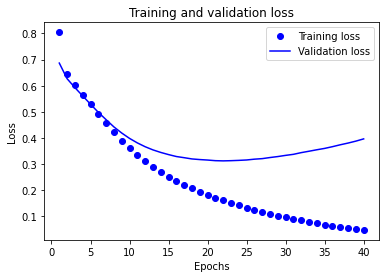

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

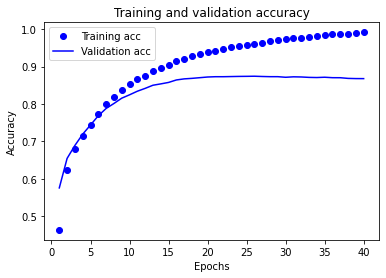

In [16]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.